<h1 align="center">Transfer learning</h1><br>
Training a Convolutional Neural Network from scratch requires a huge amount of data to train the network and amount of time for training to take place.

Transfer learning is a technique that allows us to use a `model trained` for a `certain task` as a starting point for a machine learning model for a different task.

Simply, remove the `Fully Connected layer head` from the pre-trained network (last layer) and replace it with a `softmax classifier`. This method is super simple as it allows us to treat the pre-trained CNN as a `feature extractor` and then pass those features through a Logistic Regression `classifier`.

**Data:**
- [Cats vs. Dogs](https://www.kaggle.com/biaiscience/dogs-vs-cats?select=train) Dataset.
- One file containes 25,880 images.
- Only two classes (Cat&Dog)
- Images with variable size.


**Transfer Learning Steps:**
- Taking a pre-trained CNN model (typically on the ImageNet dataset).
- Removing the FC layer head from the CNN.
- Treating the output of the body of the network as an arbitrary feature extractor with spatial dimensions M × N × C.

I'm going to use the pre-trained [Resnet](https://arxiv.org/abs/1512.03385)
<img src="resnet50.jpg" hieght="100" width="700">

# 1) PyTorch

#### `Import the needed libraries`

In [36]:
import os
import cv2
import numpy as np
from shutil import copyfile
from PIL import Image
import random
from tqdm import tqdm
import torch 
import torch.nn as nn
import torch.nn .functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchsummary import summary
from torchvision import models
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from collections import namedtuple
import pytorch_lightning as pl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### `HyperParameters initilizer`

In [37]:
#########################################
#               Parameter class         #
#########################################
class Parameters:
    def __init__(self):
        self.n_epochs = 1
        self.lr = 0.015
        self.batch_size = 64
        
P = Parameters()

#### `Create PyTorch Data Module`

- We can Create DataLoader from image file using two methods:
    * Create our dataset from TorchVision ImageFolder, the pass it to PyTorch DataLoader.
    * Create our own dataset module (has `__init__`, `__len__`, `__getitem__`) which handles the data from its path, extract the class from its path, and convert the image and its label to tensors, then also pass it to PyTorch DataLoader.

In [38]:
class DogsCatsData(Dataset):
    def __init__(self, image_paths, transform=None, target_transform=None):

        self.image_paths = image_paths
        self.transform = transform
        self.target_transform = target_transform
        
        self.image_names = os.listdir(image_paths)
        self.labels = np.array([l[:3] for l in os.listdir(image_paths)])
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        
        image_name = self.image_names[index]
        image = np.array(Image.open(os.path.join(self.image_paths, image_name)))
        label = str(self.image_names[index])[:3]
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.target_transform is not None:
            label = self.target_transform(label)
        
        return image, label

Doing `DataLoader` and `data preparation` in one class !!

In [57]:
class DataModule:
    def __init__(self,data_dir,batch_size,train_transform,test_transform,target_transform,train_val=0.8,train_test=0.8):
        self.__class__.__name__ = "DogsCatsLoader"
        super().__init__()  
        self.batch_size = batch_size
        self.data_dir = data_dir
        self.train_val = train_val
        self.train_test = train_test
        self.prepare_data()

    def prepare_data(self):
        # data folders to be created
        dic_to_create=[
            'PyTorch_Cats_Dogs',
            'PyTorch_Cats_Dogs/train',
            'PyTorch_Cats_Dogs/test',
            'PyTorch_Cats_Dogs/val',
        ]
        
        # create data folders if not created
        for dic in dic_to_create:
            try:
                os.mkdir(dic)
            except OSError:
                pass
    
        #check if data already has been splited
        if sum([os.path.getsize(os.path.join(root,d)) \
                for root, dirs, files in os.walk('PyTorch_Cats_Dogs/') \
                for d in dirs])==0:
            self.split_data_files('PyTorch_Cats_Dogs', 'cat', 'dog')
        
        # Split the data into train, validation and testing data
        self.train_data = DogsCatsData('PyTorch_Cats_Dogs/train/', train_transform, target_transform)
        self.test_data = DogsCatsData('PyTorch_Cats_Dogs/test/', test_transform, target_transform)
        self.val_data = DogsCatsData('PyTorch_Cats_Dogs/val/', train_transform, target_transform)
        
    def split_data_files(self, data_path, class_1, class_2):
 
        from sklearn.model_selection import train_test_split
        
        data_files = os.listdir(self.data_dir)        
        
        class_1 = [f for f in data_files if class_1 in f]        
        class_2 = [f for f in data_files if class_2 in f]
        
        train_class_1, test_class_1 = train_test_split(class_1,test_size=0.2,shuffle=True)
        train_class_2, test_class_2 = train_test_split(class_2,test_size=0.2,shuffle=True)
                                                                                    
        train_class_1, val_class_1 = train_test_split(train_class_1,test_size=0.2,shuffle=True)
        train_class_2, val_class_2 = train_test_split(train_class_2,test_size=0.2,shuffle=True)

        test  = [*test_class_1, *test_class_2]
        train = [*train_class_1, *train_class_2]
        val   = [*val_class_1, *val_class_2]
        
        for file_name in test:
            copyfile(os.path.join(self.data_dir, file_name) ,os.path.join(data_path, 'test', file_name))
            
        for file_name in train:
            copyfile(os.path.join(self.data_dir, file_name) ,os.path.join(data_path, 'train', file_name))
            
        for file_name in val:
            copyfile(os.path.join(self.data_dir, file_name) ,os.path.join(data_path, 'val', file_name))
    
    def checkChannel(self, img_file):
        return Image.open(img_file).getbands() == ("R", "G", "B")
    
    def train_dataloader(self):
        return DataLoader(self.train_data,
                          batch_size=self.batch_size,
                          shuffle=True)

    def val_dataloader(self):  
        return DataLoader(self.val_data,
                          batch_size=self.batch_size, 
                          shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_data, 
                          batch_size=self.batch_size,
                          shuffle=True)
    
    def teardown(self):
        del self.train_data
        del self.test_data
        del self.val_data

#### `Define the feature & target transformers for data augmentations`

In [216]:
#########################################
#          Training transformer         #
#########################################
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(224),
    transforms.Resize((224, 224)),
#     transforms.GaussianBlur(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                         std=(0.229, 0.224, 0.225))])

#########################################
#          Testing transformer         #
#########################################
test_transform =transforms.Compose([
                transforms.ToPILImage(),
#                 transforms.CenterCrop(224),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                     std=(0.229, 0.224, 0.225))])

#########################################
#            Target Decoding            #
#########################################
def target_transform(x):
    classes_dict = {'cat':0, 'dog':1}
    label_dict = {0:'cat', 1:'dog'}
    if (isinstance(x, int) or isinstance(x, np.int64)):
        return label_dict.get(x)
    return classes_dict.get(x)

#### `create instance of the data`

In [117]:
data = DataModule('CatsDogsData/', 64, train_transform, test_transform, target_transform)

In [118]:
# extract train, validation, and testing dataloader
train_loader = data.train_dataloader()
val_loader = data.val_dataloader()
test_loader = data.test_dataloader()

# clear the memory
data.teardown()

#### `Show some examples of the data`

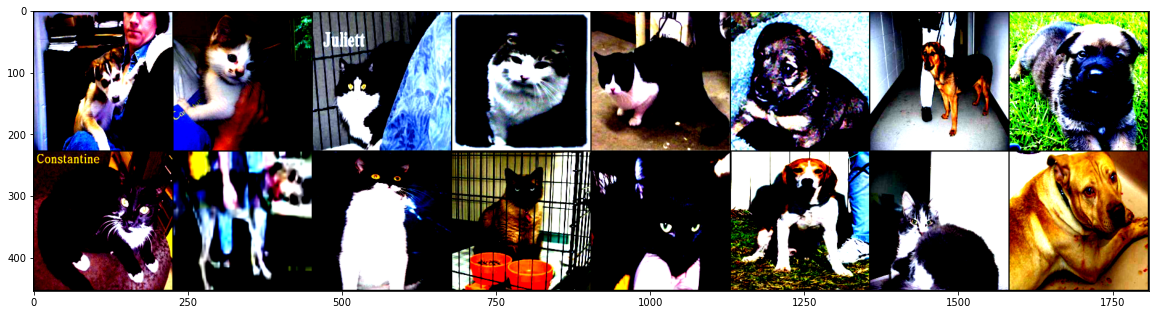

In [119]:
def imshow(inp, title=None):
    """imshow for Tensor."""
    plt.figure(figsize=(20, 8))
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
#     plt.title(str(' '*18).join(title.numpy()).title())
    plt.imshow(inp)


# Get a batch of training data
images, labels = next(iter(test_loader))

# Make a grid from batch
output = torchvision.utils.make_grid(images[:16])

imshow(output, title=labels[:16])

#### `Create PyTorch model class`

In [43]:
#########################################
#             Model inference           #
#########################################
def inference(model, loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in loader:
            images = Variable(data).to(device)
            labels = Variable(labels).to(device)
            output = model(images)
            pred = output.data.max(1, keepdim=True)[1]
            predictions = pred.eq(labels.data.view_as(pred))
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
        return correct / total

#### Define the `pre-trained model` (for feature extraction) and the `last layer` (as a classifier)

In [58]:
class TransferLearninigResnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.__class__.__name__ = "SimpleResnet"
        # define the pre-trained model
        self.resnet = self.get_resnet50(True)
        num_features = self.resnet.fc.in_features
        # define a classifier to be a head for the model
        classifier = nn.Linear(num_features, 2)
        # replace last layer of the pre-trained model with this simple classifier
        self.resnet.fc = classifier

    def get_resnet50(self, pretrained):
        resnet = models.resnet50(pretrained)
        self.freeze_layers(resnet)
        return resnet
    
    def freeze_layers(self, model):
        for child in model.children():
            for param in child.parameters():
                param.requires_grad = False

    
    def forward(self, x):
        x = self.resnet(x)
        return x

#### `Model Trainer`

In [59]:
#########################################
#            Trainer Class              #
#########################################

class Trainer:
    
    def __init__(self, model, optimizer, criterion, scheduler=None, load_path=None):
        self.__class__.__name__ = "PyTorch Trainer"
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        tqdm.refresh
        ## Setup Metric class
        self.metrics = namedtuple('Metric', ['loss', 'train_error', 'val_error'])
        
        # if model exist
        if load_path:
            self.model = torch.load(load_path)
        
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        
    def run(self, train_loader, val_loader):
        min_valid_loss = np.inf
        ## Setup Metric class
        Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])
        self.metrics = []
        self.model.train() 
        for epoch in range(P.n_epochs):
            epoch_loss = 0.0
            correct = 0
            total = 0
            data_iter = enumerate(train_loader)
            t_prog_bar = tqdm(range(len(train_loader)))
#             lr = self.scheduler.get_last_lr()[0]
            lr = self.optimizer.param_groups[0]['lr']
            for step in t_prog_bar: # iter over batches
                
                # get the input images and their corresponding labels
                batch_idx, (data, labels) = next(data_iter)
                # clear the gradient
                self.optimizer.zero_grad()
                # wrap them in a torch Variable and move tnsors to the configured device
                images, labels = Variable(data).to(device), Variable(labels).to(device)                                  
                # Forward Pass
                target = self.model(data)
                # get the predicted class from the maximum value in the output-list of class scores
                pred = target.data.max(1, keepdim=True)[1]
                predicted = pred.eq(labels.data.view_as(pred))
                # Count the correct
                correct += predicted.sum()
                # Find the Loss
                loss = self.criterion(target, labels)
#                 loss = F.nll_loss(target, labels)
                # Backward Pass
                # Calculate gradients
                loss.backward()
                # Update Weights
                self.optimizer.step()
                # Calculate total Loss
                epoch_loss += loss.item()
                # Calculate total samples
                total += labels.size(0)
                
                t_prog_bar.set_description('Epoch {}/{}, Loss: {:.4f}, lr={:.7f}'.format(epoch+1,P.n_epochs,loss.item(),lr))
                
#                 torch.cuda.empty_cache()
                del images
                del labels
                del loss
                
            valid_loss = 0.0
            self.model.eval() # Optional when not using Model Specific layer
            with torch.no_grad():
                for data, labels in val_loader:
                    # Forward Pass
                    target = self.model(data)
                    # Find the Loss
                    loss = self.criterion(target,labels)
    #                 loss = F.nll_loss(target,labels)
                    # Calculate Loss
                    valid_loss += loss.item()
                    t_prog_bar.set_description('Epoch {}/{}, Loss: {:.4f}, Val_Loss: {:.4f}, lr={:.7f}'\
                                               .format(epoch+1, P.n_epochs, loss.item(), valid_loss, lr))

            #Check point
            if min_valid_loss > valid_loss:
                print('Validation Loss Decreased ({:.6f} ===> {:.6f}) \nSaving The Model'.format(min_valid_loss/len(val_loader), 
                                                                                               valid_loss/len(val_loader)))

                min_valid_loss = valid_loss/len(val_loader)

            total_loss = epoch_loss/len(train_loader.dataset)
            train_error = 1.0 - correct/len(train_loader.dataset)  # 1 - acc
            val_error = 1.0 - inference(self.model, val_loader)  # 1 - acc

            self.metrics.append(Metric(loss=epoch_loss, 
                                       train_error=train_error,
                                       val_error=val_error))
            
#             # Decrease the lr
#             scheduler.step()

In [60]:
#########################################
#             Define the model          #
#           Define the optimizer        #
#           Define the criterion        #
#           Show model summary          #
#########################################
torch_model = TransferLearninigResnet()
# define the criterion
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.Adam(torch_model.parameters(), lr=P.lr)
# define the scheduler (learninig rate decaying)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
#summary
summary(torch_model, (3, 240, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 120, 120]           9,408
       BatchNorm2d-2         [-1, 64, 120, 120]             128
              ReLU-3         [-1, 64, 120, 120]               0
         MaxPool2d-4           [-1, 64, 60, 60]               0
            Conv2d-5           [-1, 64, 60, 60]           4,096
       BatchNorm2d-6           [-1, 64, 60, 60]             128
              ReLU-7           [-1, 64, 60, 60]               0
            Conv2d-8           [-1, 64, 60, 60]          36,864
       BatchNorm2d-9           [-1, 64, 60, 60]             128
             ReLU-10           [-1, 64, 60, 60]               0
           Conv2d-11          [-1, 256, 60, 60]          16,384
      BatchNorm2d-12          [-1, 256, 60, 60]             512
           Conv2d-13          [-1, 256, 60, 60]          16,384
      BatchNorm2d-14          [-1, 256,

In [47]:
#########################################
#      Start Training the model         #
#########################################
trainer = Trainer(torch_model, optimizer, criterion)
trainer.run(train_loader, val_loader)

Epoch 1/1, Loss: 0.1050, lr=0.0150000: 100%|███████████████████████████████████████| 259/259 [1:00:24<00:00, 14.00s/it]


Validation Loss Decreased (inf ===> 0.270250) 
Saving The Model


#### `Saving the model`

In [49]:
torch.save(torch_model, 'Cats_Dogs_ResNet50_2.pt')

#### `Test the model`

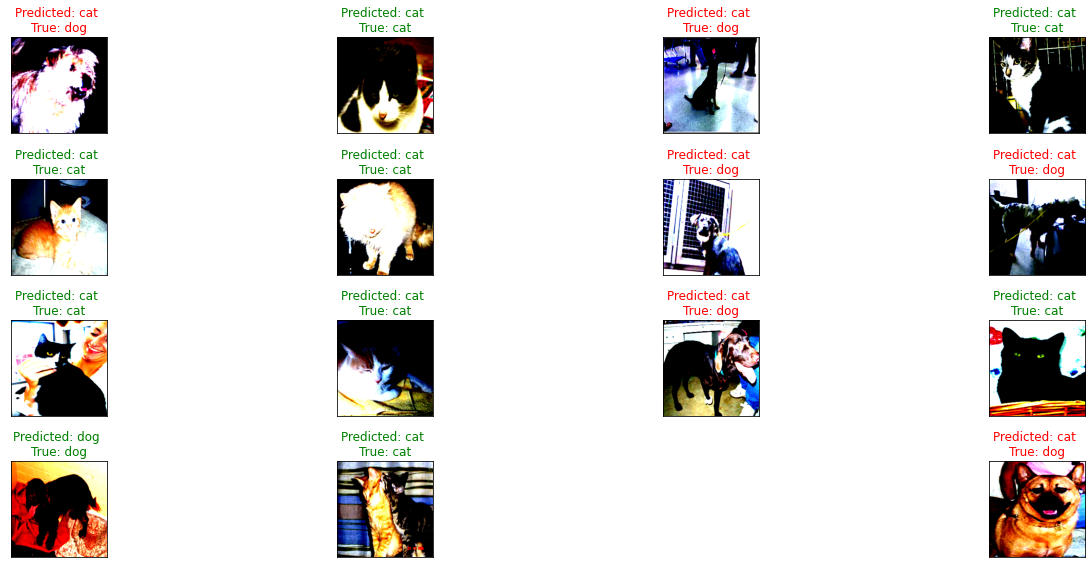

In [252]:
test = iter(test_loader)
plt.figure(figsize=(20, 8))
for i in range(16):
    image, label = next(test)
    idx = np.random.randint(P.batch_size, size=1)[0]
    output = torch_model(image[[idx]])
    predicted = output.data.max(1, keepdim=True)[1]
    pred = target_transform(predicted.numpy()[0][0])
    act = target_transform(label[idx].numpy().tolist())
    plt.tight_layout()
    plt.subplot(4,4,i+1)
    plt.title("Predicted: {} \nTrue: {}".format(pred, act),color=("green" if pred==act else "red"))
    plt.imshow((np.clip(image[idx].numpy().transpose((1, 2, 0)), 0, 1)))
    plt.xticks([])
    plt.yticks([])

> ### It's resonable with a single epoch !

# 2) TensorFlow

#### `Import the needed libraries`

In [68]:
import tensorflow as tf
import keras 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.layers import Dense ,Flatten ,MaxPool2D ,Conv2D ,GlobalMaxPooling2D
from keras.models import Model, save_model
from keras.applications import resnet
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import datetime

#### `Split the data dictionary into train/test dictionaries`

In [13]:
def split_data_to_two_classes(src ,train_path ,test_path , val_path, class_1_name ,class_2_name):

    #Create dictionaries to split the data into trainig and testin sets and split them into two classes(Cats and dogs)
    dic_to_create=[
        'TensorFlow_Cats_Dogs',
        'TensorFlow_Cats_Dogs/train',
        'TensorFlow_Cats_Dogs/train/cat',
        'TensorFlow_Cats_Dogs/train/dog',
        'TensorFlow_Cats_Dogs/test',
        'TensorFlow_Cats_Dogs/test/cat',
        'TensorFlow_Cats_Dogs/test/dog',
        'TensorFlow_Cats_Dogs/val',
        'TensorFlow_Cats_Dogs/val/cat',
        'TensorFlow_Cats_Dogs/val/dog',
    ]

    for dic in dic_to_create:
        try:
            os.mkdir(dic)
        except OSError:
            pass
        
    data_files = os.listdir(src)    
    
    #check if data already has been splited
    if sum([os.path.getsize(os.path.join(root,d)) \
            for root, dirs, files in os.walk('TensorFlow_Cats_Dogs/') \
            for d in dirs])>3:
        return True

    class_1 = [f for f in data_files if class_1_name in f]
    class_2 = [f for f in data_files if class_2_name in f]
    
    train_class_1, test_class_1 = train_test_split(class_1,test_size=0.2,shuffle=True)
    train_class_2, test_class_2 = train_test_split(class_2,test_size=0.2,shuffle=True)

    train_class_1, val_class_1 = train_test_split(train_class_1,test_size=0.2,shuffle=True)
    train_class_2, val_class_2 = train_test_split(train_class_2,test_size=0.2,shuffle=True)
    
    data = [(train_class_1, train_class_2, train_path),
            (test_class_1, test_class_2, test_path),
            (val_class_1, val_class_2, val_path)]

    # copy the splited data to the new files
    for class_1, class_2, data_path in data:
        for file_name in (progbar := tqdm(class_1)):
            copyfile(os.path.join(src, file_name) ,os.path.join(data_path, class_1_name, file_name))
            progbar.set_description(f"{data_path.split('/')[1].title()} Data {(class_1_name)}: "
                                    f"Image {file_name} is done !")

        for file_name in (progbar := tqdm(class_2)):
            copyfile(os.path.join(src, file_name) ,os.path.join(data_path, class_2_name, file_name))
            progbar.set_description(f"{data_path.split('/')[1].title()} Data {(class_2_name)}: "
                                    f"Image {file_name} is done !")

In [244]:
split_data_to_two_classes('CatsDogsData/', 
                          'TensorFlow_Cats_Dogs/train/', 
                          'TensorFlow_Cats_Dogs/test/', 
                          'TensorFlow_Cats_Dogs/val/',
                          'cat', 'dog')

Val Data dog: Image dog.479.jpg is done !: 100%|██████████████████████████████████| 2000/2000 [00:07<00:00, 264.54it/s]


#### `Data Augmentation` (Like Transformers in PyTorch)

In [14]:
#########################################
#        Data & Data Generator          #
#########################################
# Training Data Generator
train_data_generator=ImageDataGenerator(rotation_range=180,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        channel_shift_range=0.0,
                                        rescale=1/255,
                                        validation_split=0.2)

# Testing Data Generator
test_data_generator=ImageDataGenerator(rescale=1/255)




# Training Data 
train_data = train_data_generator.flow_from_directory('TensorFlow_Cats_Dogs/train',
                                                      target_size=(240,240),
                                                      color_mode='rgb',
                                                      batch_size=P.batch_size,
                                                      shuffle=True)

# Validation Data
val_data = train_data_generator.flow_from_directory('TensorFlow_Cats_Dogs/val',
                                                      target_size=(240,240),
                                                      color_mode='rgb',
                                                      batch_size=P.batch_size,
                                                      shuffle=True)

# Testing Data
test_data = test_data_generator.flow_from_directory('TensorFlow_Cats_Dogs/test',
                                     target_size=(240,240),
                                     color_mode='rgb',
                                     batch_size=P.batch_size,
                                     shuffle=True)

Found 16563 images belonging to 2 classes.
Found 4141 images belonging to 2 classes.
Found 5176 images belonging to 2 classes.


#### `Show examples of the data`

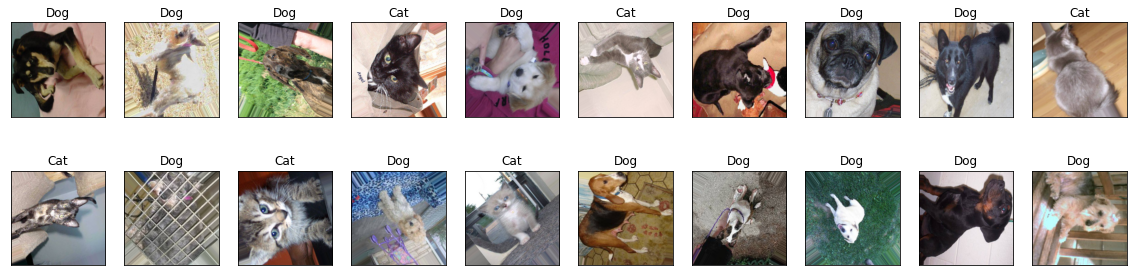

In [55]:
plt.figure(figsize=(20,5))
for i in range(20):
    imgs, labels = test_data.next()
    idx = np.random.randint(64, size=(1,))
    plt.subplot(2,10,i+1)
    label = {1.0:'Cat', 0.0:'Dog'}.get(labels[idx][0][0])
    plt.title(label)
    image = np.squeeze(imgs[idx], 0)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

plt.show()

#### `Build the model`

In [17]:
base_model = resnet.ResNet50(include_top=False,
                             weights='imagenet',
                             input_tensor=None,
                             input_shape=(240, 240, 3))

# freeze all layers
for layer in base_model.layers:
    layer.trainable=False

# use all layer as a feature extractor, and replace the output layer with the classifier
# add new classifier layers
flatten = Flatten()(base_model.layers[-1].output)
output = Dense(1, activation='sigmoid')(flatten)
# define new model
tensorflow_model = Model(inputs=base_model.inputs, outputs=output)

# define optimizer 
optimizer = Adam(learning_rate=0.001)
 
# compile the model 
tensorflow_model.compile(loss='binary_crossentropy' ,optimizer=optimizer)
tensorflow_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 246, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 120, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

#### `Model's Callbacks`

In [18]:
log_dir = 'pre_log/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

my_callback = [keras.callbacks.EarlyStopping(verbose=2,
                                             monitor='val_loss'),
               keras.callbacks.ModelCheckpoint('../cats an dogs with transfer learning',
                                              monitor='val_loss',
                                              verbose=2,
                                              save_best_only=True,
                                              save_weights_only=True,
                                              mode='auto'),
#                keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
              ]

#### `Start Training`

In [20]:
model_history = tensorflow_model.fit_generator(generator=train_data,
                                               epochs=P.n_epochs,
                                               validation_data=val_data,
#                                                callbacks=my_callback,
                                               verbose=1)

<ipython-input-20-daa551524b81>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = tensorflow_model.fit_generator(generator=train_data,


259/259 [==============================] - 2807s 11s/step - loss: 0.9460 - val_loss: 0.6951


#### `Save the model`

In [23]:
tensorflow_model.save('tensorflow_model.h5')